In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
#from IPython.display import clear_output
#!pip install pydicom
#!pip install catalyst
#!pip install segmentation_models_pytorch
#!pip install albumentations==0.3.2
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir # albu.lambda 지원을 위해 설치
#clear_output()

In [46]:
import cv2
import collections
import time 
from tqdm import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import copy
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import pydicom
import time
import sys
sys.path.append('/content/drive/My Drive/ct')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR


import albumentations as albu
from albumentations import torch as AT
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ScalarReader, ReaderCompose, LambdaReader#ImageReader
from catalyst.dl.runner import SupervisedRunner
#from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback
from catalyst.dl.callbacks import JaccardCallback,PrecisionRecallF1ScoreCallback
import segmentation_models_pytorch as smp

In [47]:
seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Load


In [48]:
path = '../data/data/'
original_path = '00002057_s1_Anonymized_00002057_converted_250_'
object_path = 'nii/00002057_s2_Anonymized_Segmented__00002057_converted_250.nii'
 
train_meta = pd.DataFrame(
                        {
                        # 이후 데이터가 추가될 경우를 생각하여 5번 반복하였습니다.
                        # 실제로는 N개의 샘플이 추가된다면 N개의 row를 갖는 mata 데이터가 생성됩니다.
                         'original' :  [path+ '원본/'      + original_path for i in range(3)],
                         'musle'    :  [path+ '근육/'      + object_path for i in range(3)],
                         'fat'      :  [path+ '피하지방/'  + object_path for i in range(3)],
                         'innerfat' :  [path+ '내장지방/'  + object_path for i in range(3)],
                         'part'     :  [(path,object_path)for i in range(3)]
                        }            
                    )

test_meta = pd.DataFrame(
                        {
                         'original' :  [path+ '원본/'      + original_path for i in range(2)],
                         'musle'    :  [path+ '근육/'      + object_path for i in range(2)],
                         'fat'      :  [path+ '피하지방/'  + object_path for i in range(2)],
                         'innerfat' :  [path+ '내장지방/'  + object_path for i in range(2)],
                          'part'     :  [(path,object_path)for i in range(2)]
                        }            
                    )

train_meta

,original,musle,fat,innerfat,part
0,../data/data/원본/00002057_s1_Anonymized_0000205...,../data/data/근육/nii/00002057_s2_Anonymized_Seg...,../data/data/피하지방/nii/00002057_s2_Anonymized_S...,../data/data/내장지방/nii/00002057_s2_Anonymized_S...,"(../data/data/, nii/00002057_s2_Anonymized_Seg..."
1,../data/data/원본/00002057_s1_Anonymized_0000205...,../data/data/근육/nii/00002057_s2_Anonymized_Seg...,../data/data/피하지방/nii/00002057_s2_Anonymized_S...,../data/data/내장지방/nii/00002057_s2_Anonymized_S...,"(../data/data/, nii/00002057_s2_Anonymized_Seg..."
2,../data/data/원본/00002057_s1_Anonymized_0000205...,../data/data/근육/nii/00002057_s2_Anonymized_Seg...,../data/data/피하지방/nii/00002057_s2_Anonymized_S...,../data/data/내장지방/nii/00002057_s2_Anonymized_S...,"(../data/data/, nii/00002057_s2_Anonymized_Seg..."


### data preprocess

In [49]:
index = 1

In [55]:
person_idx, img_index= divmod(index,40)
img_index += 75

meta_data = test_meta.copy()

cts_path  = meta_data.loc[person_idx, 'original']
ct = pydicom.dcmread(cts_path + str(img_index).zfill(3)).pixel_array


ct = ct[60:-60,60:-60]
image = ct / ct.max() * 255
image = Image.fromarray(image)
image = np.array(image.convert('L'))
## mask 읽어오기 - nii
ct_masks = []
for body in ['근육/', '피하지방/','내장지방/']:
    mask_path = meta_data.loc[person_idx, 'part'][0] + body + meta_data.loc[person_idx, 'part'][1]
    ct_mask = nib.load(mask_path)
    ct_mask = np.array(ct_mask.get_fdata()[60:-60,60:-60,img_index,0]) # aixs 3가 1개 존재 0번으로 인덱싱=#---np.rot90 있던자리
    ct_masks.append(ct_mask[...,np.newaxis])
target_mask = np.concatenate(ct_masks, axis = 2)
#target_mask = np.flip(target_mask, 0)

# backgraound 채널 추가
background = target_mask.sum(axis = 2) #(128, 128, 채널(musle, fat, innerfat))
background = np.where(background != 0, 0, 1)[...,np.newaxis]
target_mask = np.concatenate([target_mask, background], axis = 2)
        
target_mask = ToTensor()(image=target_mask)['image']
image = ToTensor()(image=image)['image']


compose = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((256,256))])
target_mask = compose(target_mask)
image = compose(image)


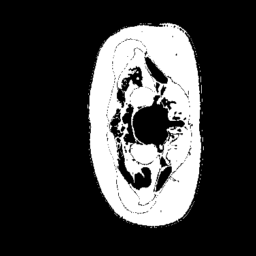

In [60]:
target_mask

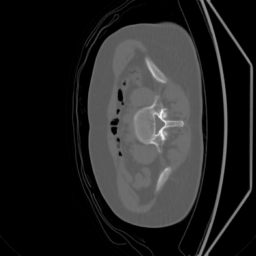

In [62]:
image

In [ ]:
image.view(1,256,256), target_mask

In [16]:
class CT_Dataset(torch.utils.data.Dataset):
    def __init__(self, meta_data, transform=None, preprocessing=None):
        self.transforms = transform
        self.meta_data = meta_data
        self.preprocessing = preprocessing
        
        #self.len = np.array(nib.load(self.cts_path).get_fdata()).shape[-1]
        
    def __getitem__(self,index):
        person_idx, img_index= divmod(index,40)
        img_index += 75

        ## 원본 읽어오기 - pydicom
        cts_path  = self.meta_data.loc[person_idx, 'original']
        ct = pydicom.dcmread(cts_path + str(img_index).zfill(3)).pixel_array
        ct = ct[60:-60,60:-60]
        image = ct / ct.max() * 255
        image = Image.fromarray(image)
        image = np.array(image.convert('L'))
        ## mask 읽어오기 - nii
        ct_masks = []
        for body in ['근육/', '피하지방/','내장지방/']:
            mask_path = self.meta_data.loc[person_idx, 'part'][0] + body + self.meta_data.loc[person_idx, 'part'][1]
            ct_mask = nib.load(mask_path)
            ct_mask = np.array(ct_mask.get_fdata()[60:-60,60:-60,img_index,0]) # aixs 3가 1개 존재 0번으로 인덱싱=#---np.rot90 있던자리
            ct_masks.append(ct_mask[...,np.newaxis])
        target_mask = np.concatenate(ct_masks, axis = 2)
        #target_mask = np.flip(target_mask, 0)
        
        # backgraound 채널 추가
        background = target_mask.sum(axis = 2) #(128, 128, 채널(musle, fat, innerfat))
        background = np.where(background != 0, 0, 1)[...,np.newaxis]
        target_mask = np.concatenate([target_mask, background], axis = 2)
 

        if self.transforms is not None:
            augument = self.transforms(image=image,mask=target_mask)
            image = augument['image']
            target_mask = augument['mask']

        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=target_mask)
            image = preprocessed['image']
            target_mask = preprocessed['mask']

        target_mask = ToTensor()(image=target_mask)['image']
        image = ToTensor()(image=image)['image']
        return image.view(1,256,256), target_mask
    
    def __len__(self):
        return len(self.meta_data) * 40
 
 
imgsize = 256
transforms = {
    'both': Compose([
                    Resize(imgsize,imgsize),
                    # HorizontalFlip(p=0.5), 
                    # OneOf([ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03), GridDistortion(), OpticalDistortion(distort_limit=2, shift_limit=0.5)], p=0.3),
                    ]),
    
    'image': Compose([
                    OneOf([RandomBrightness(limit=0.1, p=0.4), RandomContrast(limit=0.1, p=0.4)]),
                    GaussNoise(),
                    Blur(p=0.1, blur_limit = 3),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]),
}
 
 
df = train_meta
cts_path = df['original'].tolist()
masks_path = df['part'].tolist()
dataset = CT_Dataset(train_meta, transform=transforms['both'], preprocessing = None)

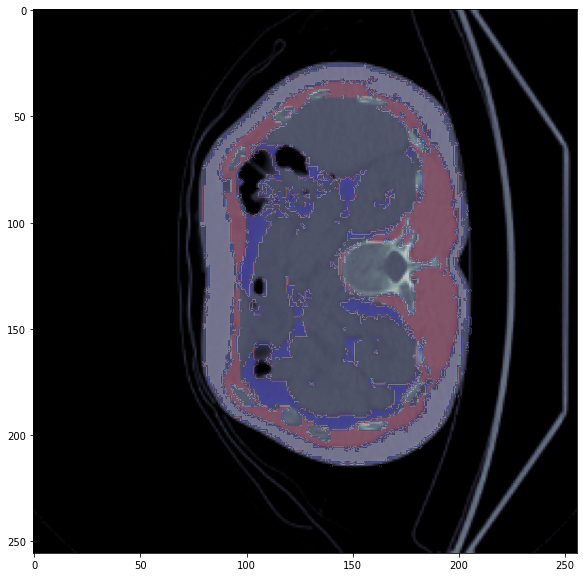

In [17]:
img_id = 39
plt.figure(figsize=(10,10))
plt.imshow(dataset[img_id][0].permute(1,2,0).numpy()[:,:,0], cmap='bone') # 원본 # permute는 축 변경
plt.imshow(dataset[img_id][1].permute(1,2,0).numpy().argmax(axis = 2), alpha=0.2, cmap='flag') # 레이블
plt.show()

In [35]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels = 1,
    classes=4, 
    activation=ACTIVATION,
)

In [36]:
"""
from albumentations import pytorch as AT
def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        #albu.Lambda(image=To_tensor, mask=To_tensor),
    ]
    return albu.Compose(_transform)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
"""

'\nfrom albumentations import pytorch as AT\ndef get_preprocessing(preprocessing_fn):\n    _transform = [\n        albu.Lambda(image=preprocessing_fn),\n        #albu.Lambda(image=To_tensor, mask=To_tensor),\n    ]\n    return albu.Compose(_transform)\npreprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)\n'

In [37]:
num_workers = 0
bs = 16
train_dataset =  CT_Dataset(train_meta, transform=transforms['both'])#, preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CT_Dataset(test_meta, transform=transforms['both'])#,preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [39]:
num_epochs = 100
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])

scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.DiceLoss(eps=1.)
runner = SupervisedRunner()

In [40]:
num_epochs

100

In [41]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(),
               JaccardCallback(),
               EarlyStoppingCallback(patience=5, min_delta=0.001),
               ],
    # logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

1/100 * Epoch (train): 100% 8/8 [00:44<00:00,  5.57s/it, dice=0.420, iou=0.265, loss=-1.596e-01]
1/100 * Epoch (valid): 100% 5/5 [00:29<00:00,  5.90s/it, dice=0.077, iou=0.040, loss=0.954]
[2020-11-13 14:34:08,560] 
1/100 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.3942 | iou=0.2458 | loss=0.2448
1/100 * Epoch 1 (valid): dice=0.0773 | iou=0.0402 | loss=0.8913
2/100 * Epoch (train): 100% 8/8 [00:44<00:00,  5.59s/it, dice=0.363, iou=0.222, loss=0.604]     
2/100 * Epoch (valid): 100% 5/5 [00:29<00:00,  5.87s/it, dice=0.156, iou=0.085, loss=1.143]
[2020-11-13 14:35:22,648] 
2/100 * Epoch 2 (_base): lr=0.0100 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.4043 | iou=0.2535 | loss=-6.581e+00
2/100 * Epoch 2 (valid): dice=0.1574 | iou=0.0854 | loss=1.1190
3/100 * Epoch (train): 100% 8/8 [00:44<00:00,  5.52s/it, dice=0.375, iou=0.231, loss=0.339]
3/100 * Epoch (valid): 100% 5/5 [00:29<00:00,  5.83s/it, dice=0.216, iou=0.121, loss=1.148]
[2020-11-13 14:36:

## train result visulization

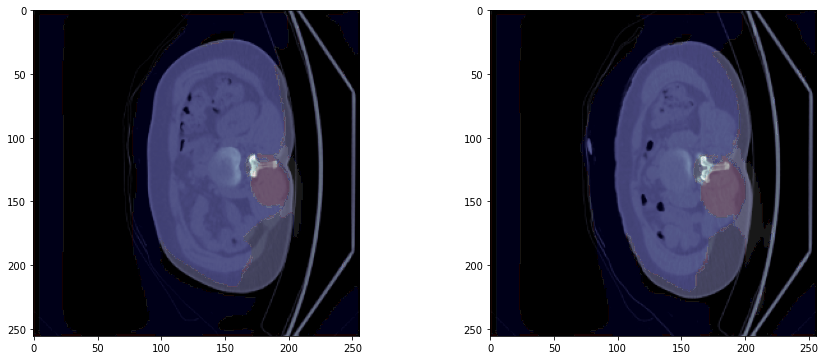

In [42]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
for i, train_batch in enumerate(loaders['train']):
    train_out = runner.predict_batch({"features": train_batch[0].cuda()})['logits']
    plt.imshow(train_batch[0][0].permute(1,2,0).numpy()[:,:,0],
               cmap='bone') # 원본 # permute는 축 변경
    plt.imshow(train_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
               alpha=0.1, cmap='flag') # 레이블
    break
    
plt.subplot(1,2,2)
for i, test_batch in enumerate(loaders['train']):
    test_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    plt.imshow(test_batch[0][0].permute(1,2,0).numpy()[:,:,0],
               cmap='bone') # 원본 # permute는 축 변경
    plt.imshow(test_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
               alpha=0.1, cmap='flag') # 레이블
    break
plt.show()

In [43]:
for data, target in train_loader:
    print(data.shape,target.shape)
    break

torch.Size([16, 1, 256, 256]) torch.Size([16, 4, 256, 256])


In [44]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        BCE = nn.BCELoss()(inputs, targets)
        num = targets.size(0)     
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        intersection = (inputs * targets).sum(1) 
        dice = (2.*intersection + smooth)/(inputs.sum(1) + targets.sum(1) + smooth) 
        dice_loss = 1 - dice.sum()/num
 
        loss_final = 3*BCE + dice_loss
        return loss_final
    
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100
 
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score
    
 
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = 1
        self.gamma = 2
        
    def forward(self, inputs, targets):
        num = targets.size(0)
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        batch_loss = self.alpha * (1 - inputs) ** self.gamma * BCE_loss
        loss = batch_loss.mean()
        
        return loss
 
def compute_iou(model, loader, threshold=0.3):
    model.eval()
    valloss = 0
    
    with torch.no_grad():
        for data, target in loader:
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
 
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            #print(out_cut.shape)
            #print(target.data.shape)
            #return
 
            picloss = DiceScore()(out_cut, target.data.cpu().numpy())
            valloss += picloss
 
    return valloss /len(loader)
 

In [45]:
compute_iou(runner.model, train_loader)

0.45361174037315277